<a href="https://colab.research.google.com/github/ImranNust/Coursera_DeepLearningSpecialization/blob/master/VGG16_For_Dog_and_Cats_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = r"/content/drive/MyDrive/Colab Notebooks/Datasets/Cat_Dog_data"

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize([224,224]),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize([224,224]),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [4]:
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 2048)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(0.4)),
                          ('fc2', nn.Linear(2048, 512)),
                          ('relu2', nn.ReLU()),
                          ('dropout2', nn.Dropout(0.4)),
                          ('fc3', nn.Linear(512, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:

epochs = 15
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch: {epoch+1}/{epochs}, "
                  f"Train loss: {running_loss/print_every:.3f}, "
                  f"Test loss: {test_loss/len(testloader):.3f}, "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch: 1/15, Train loss: 29.812, Test loss: 5.303, Test accuracy: 0.542
Epoch: 2/15, Train loss: 3.009, Test loss: 0.163, Test accuracy: 0.950
Epoch: 2/15, Train loss: 0.168, Test loss: 0.142, Test accuracy: 0.977
Epoch: 3/15, Train loss: 0.055, Test loss: 0.246, Test accuracy: 0.976
Epoch: 3/15, Train loss: 0.058, Test loss: 0.102, Test accuracy: 0.970
Epoch: 4/15, Train loss: 0.006, Test loss: 0.198, Test accuracy: 0.976
Epoch: 4/15, Train loss: 0.005, Test loss: 0.240, Test accuracy: 0.976
Epoch: 5/15, Train loss: 0.013, Test loss: 0.120, Test accuracy: 0.977
Epoch: 5/15, Train loss: 0.047, Test loss: 0.330, Test accuracy: 0.976
Epoch: 6/15, Train loss: 0.006, Test loss: 0.448, Test accuracy: 0.976
Epoch: 7/15, Train loss: 0.022, Test loss: 0.405, Test accuracy: 0.976
Epoch: 7/15, Train loss: 0.000, Test loss: 0.232, Test accuracy: 0.976
Epoch: 8/15, Train loss: 0.002, Test loss: 0.173, Test accuracy: 0.976
Epoch: 8/15, Train loss: 0.001, Test loss: 0.142, Test accuracy: 0.976
Epoch

In [7]:
def denormalise(image):
    mean = [0.485, 0.456, 0.406]
    stdd = [0.229, 0.224, 0.225]
    image = (image * stdd + mean)
    return image

In [13]:
def view_classification(img, prob):
  # Denormalizing the image
  img = img[0].cpu().numpy().transpose(1,2,0);
  img = denormalise(img)
  img = (img * 255).astype(np.uint8)


  prob = prob.cpu().numpy().squeeze()
  fig, (ax1, ax2) = plt.subplots(figsize=(8,10), ncols=2)
  ax1.imshow(img)
  ax1.axis('off')
  ax2.barh(np.arange(2), prob, align='edge')
  ax2.set_aspect(0.09)
  ax2.set_yticks(np.arange(2))
  ax2.set_yticklabels(['Cat',
                      'Dog'], size='small');
  ax2.set_title('Class Probability')
  ax2.set_xlim(0, 1.1)
  plt.tight_layout()

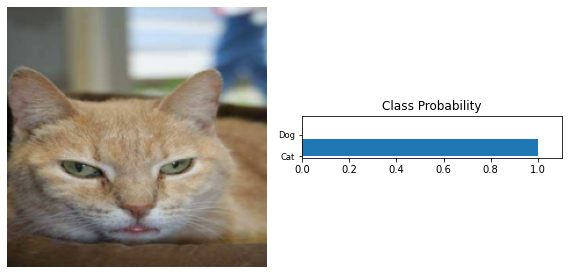

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, label = next(iter(trainloader))
images, labels = images.to(device), labels.to(device)
img = images[1].unsqueeze(0)
with torch.no_grad():
  logits = model.forward(img)

prob = F.softmax(logits, dim=1)

view_classification(img, prob)